In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sb
import emcee
sb.set_style('white')
%config InlineBackend.figure_format = 'retina'

In [2]:
from model_joint_lnhood import *

In [3]:
Ener,no_events,e_min,e_max = np.loadtxt('data/OC_no_events_9_bins.txt',usecols=(0,1,2,3),unpack=True)

In [4]:
mask = no_events != 0.0
Ener = Ener[mask]
no_events = no_events[mask]
e_min = e_min[mask]
e_max = e_max[mask]

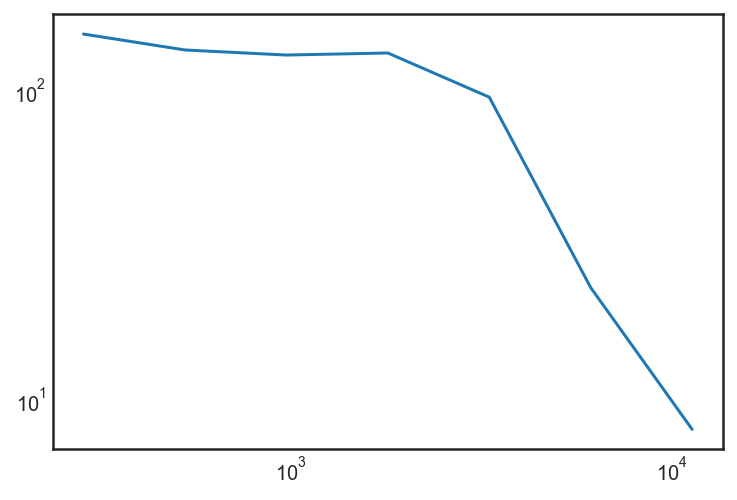

In [5]:
plt.loglog(Ener,no_events);

In [6]:
from scipy import optimize as op

In [7]:
fun = lambda *args: - (lnhood1(*args) + lnhood2(*args))

In [8]:
mid = [1.,3.,-6.,-6.,1.5,-6.,1.5]
bnds = ((0.,3.), (2.,4.), (-18.,0.),(-15.,0.),(0.,5.),(-15.,0.),(0.,5.))

In [9]:
result = op.minimize(fun, mid, args=(no_events,e_min,e_max),method = 'TNC',bounds=bnds)

In [10]:
print result.x

[  1.0872044    3.24685837  -8.18482374  -9.84273555   0.61382799
 -11.8654748    1.01335592]


In [11]:
p_list = [0.,3., 2.,4.,-18.,0.,-15.,0.,0.,5.,-15.,0.,0.,5.]

In [12]:
nwalkers = 200
ndim = (len(p_list)/2) 

In [13]:
print ndim

7


In [14]:
z = np.zeros((ndim,nwalkers))

In [15]:
h = 1e-2

pos_i=[]

for i in range(ndim):
    z[i,:] = result.x[i] + h*np.random.randn(nwalkers)

for i in range(nwalkers):
    pos_i.append(np.array([z[0,i],z[1,i],z[2,i],z[3,i],z[4,i],
                          z[5,i],z[6,i]]))

In [16]:
b_steps, steps = 2000, 1000

In [17]:
sampler = emcee.EnsembleSampler(nwalkers,ndim,event_lnpost, 
                                args=(no_events,e_min,e_max,p_list),
                                threads = 2)

In [18]:
pos,prob,state=sampler.run_mcmc(pos_i, b_steps)

In [19]:
print sampler.acceptance_fraction.mean()

0.47090499999999996


In [20]:
sampler.reset()

In [21]:
_,_,_=sampler.run_mcmc(pos, steps, rstate0=state)

In [22]:
print sampler.acceptance_fraction.mean()

0.47697500000000004


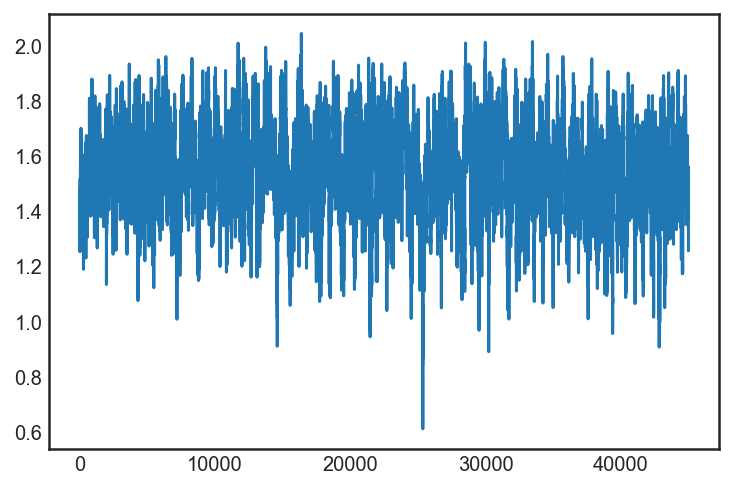

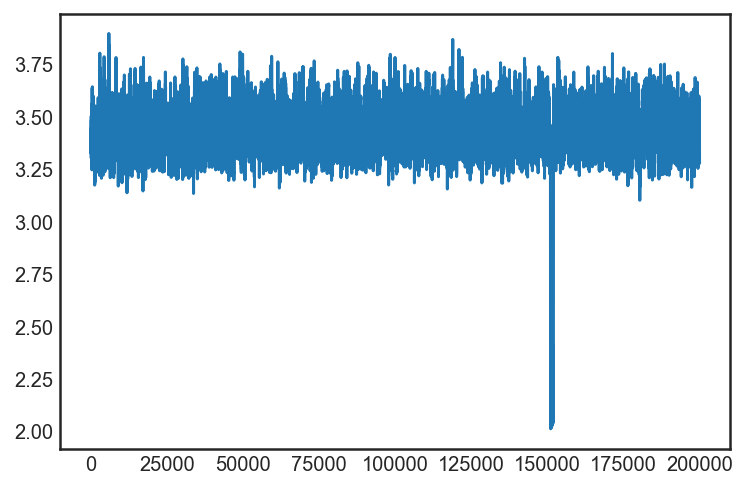

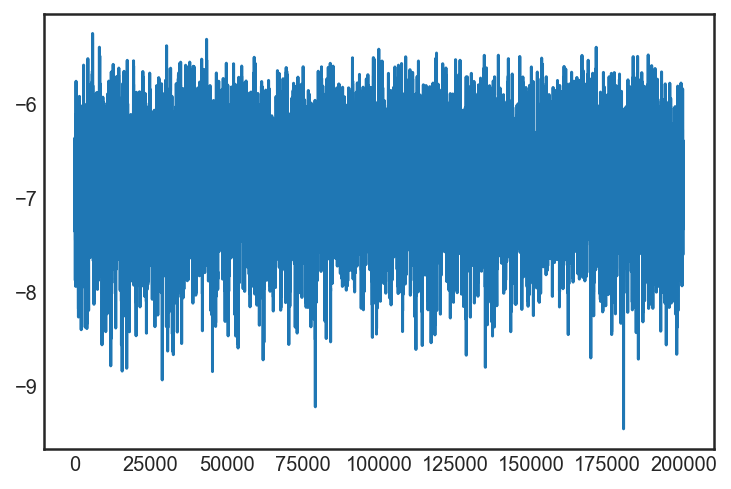

In [41]:
plt.figure()
plt.plot(sampler.flatchain[155000:,0]);
plt.figure()
plt.plot(sampler.flatchain[:,1]);
plt.figure()
plt.plot(sampler.flatchain[:,2]);

In [24]:
import corner as corner 

In [25]:
labels = [r'$\Gamma$',r'$log10(E_{cut})$','log10(N0)'
          ,r'$log10(N_N1)$',r'$\alpha_1$'
         ,r'$log10(N_N2)$',r'$\alpha_2$']

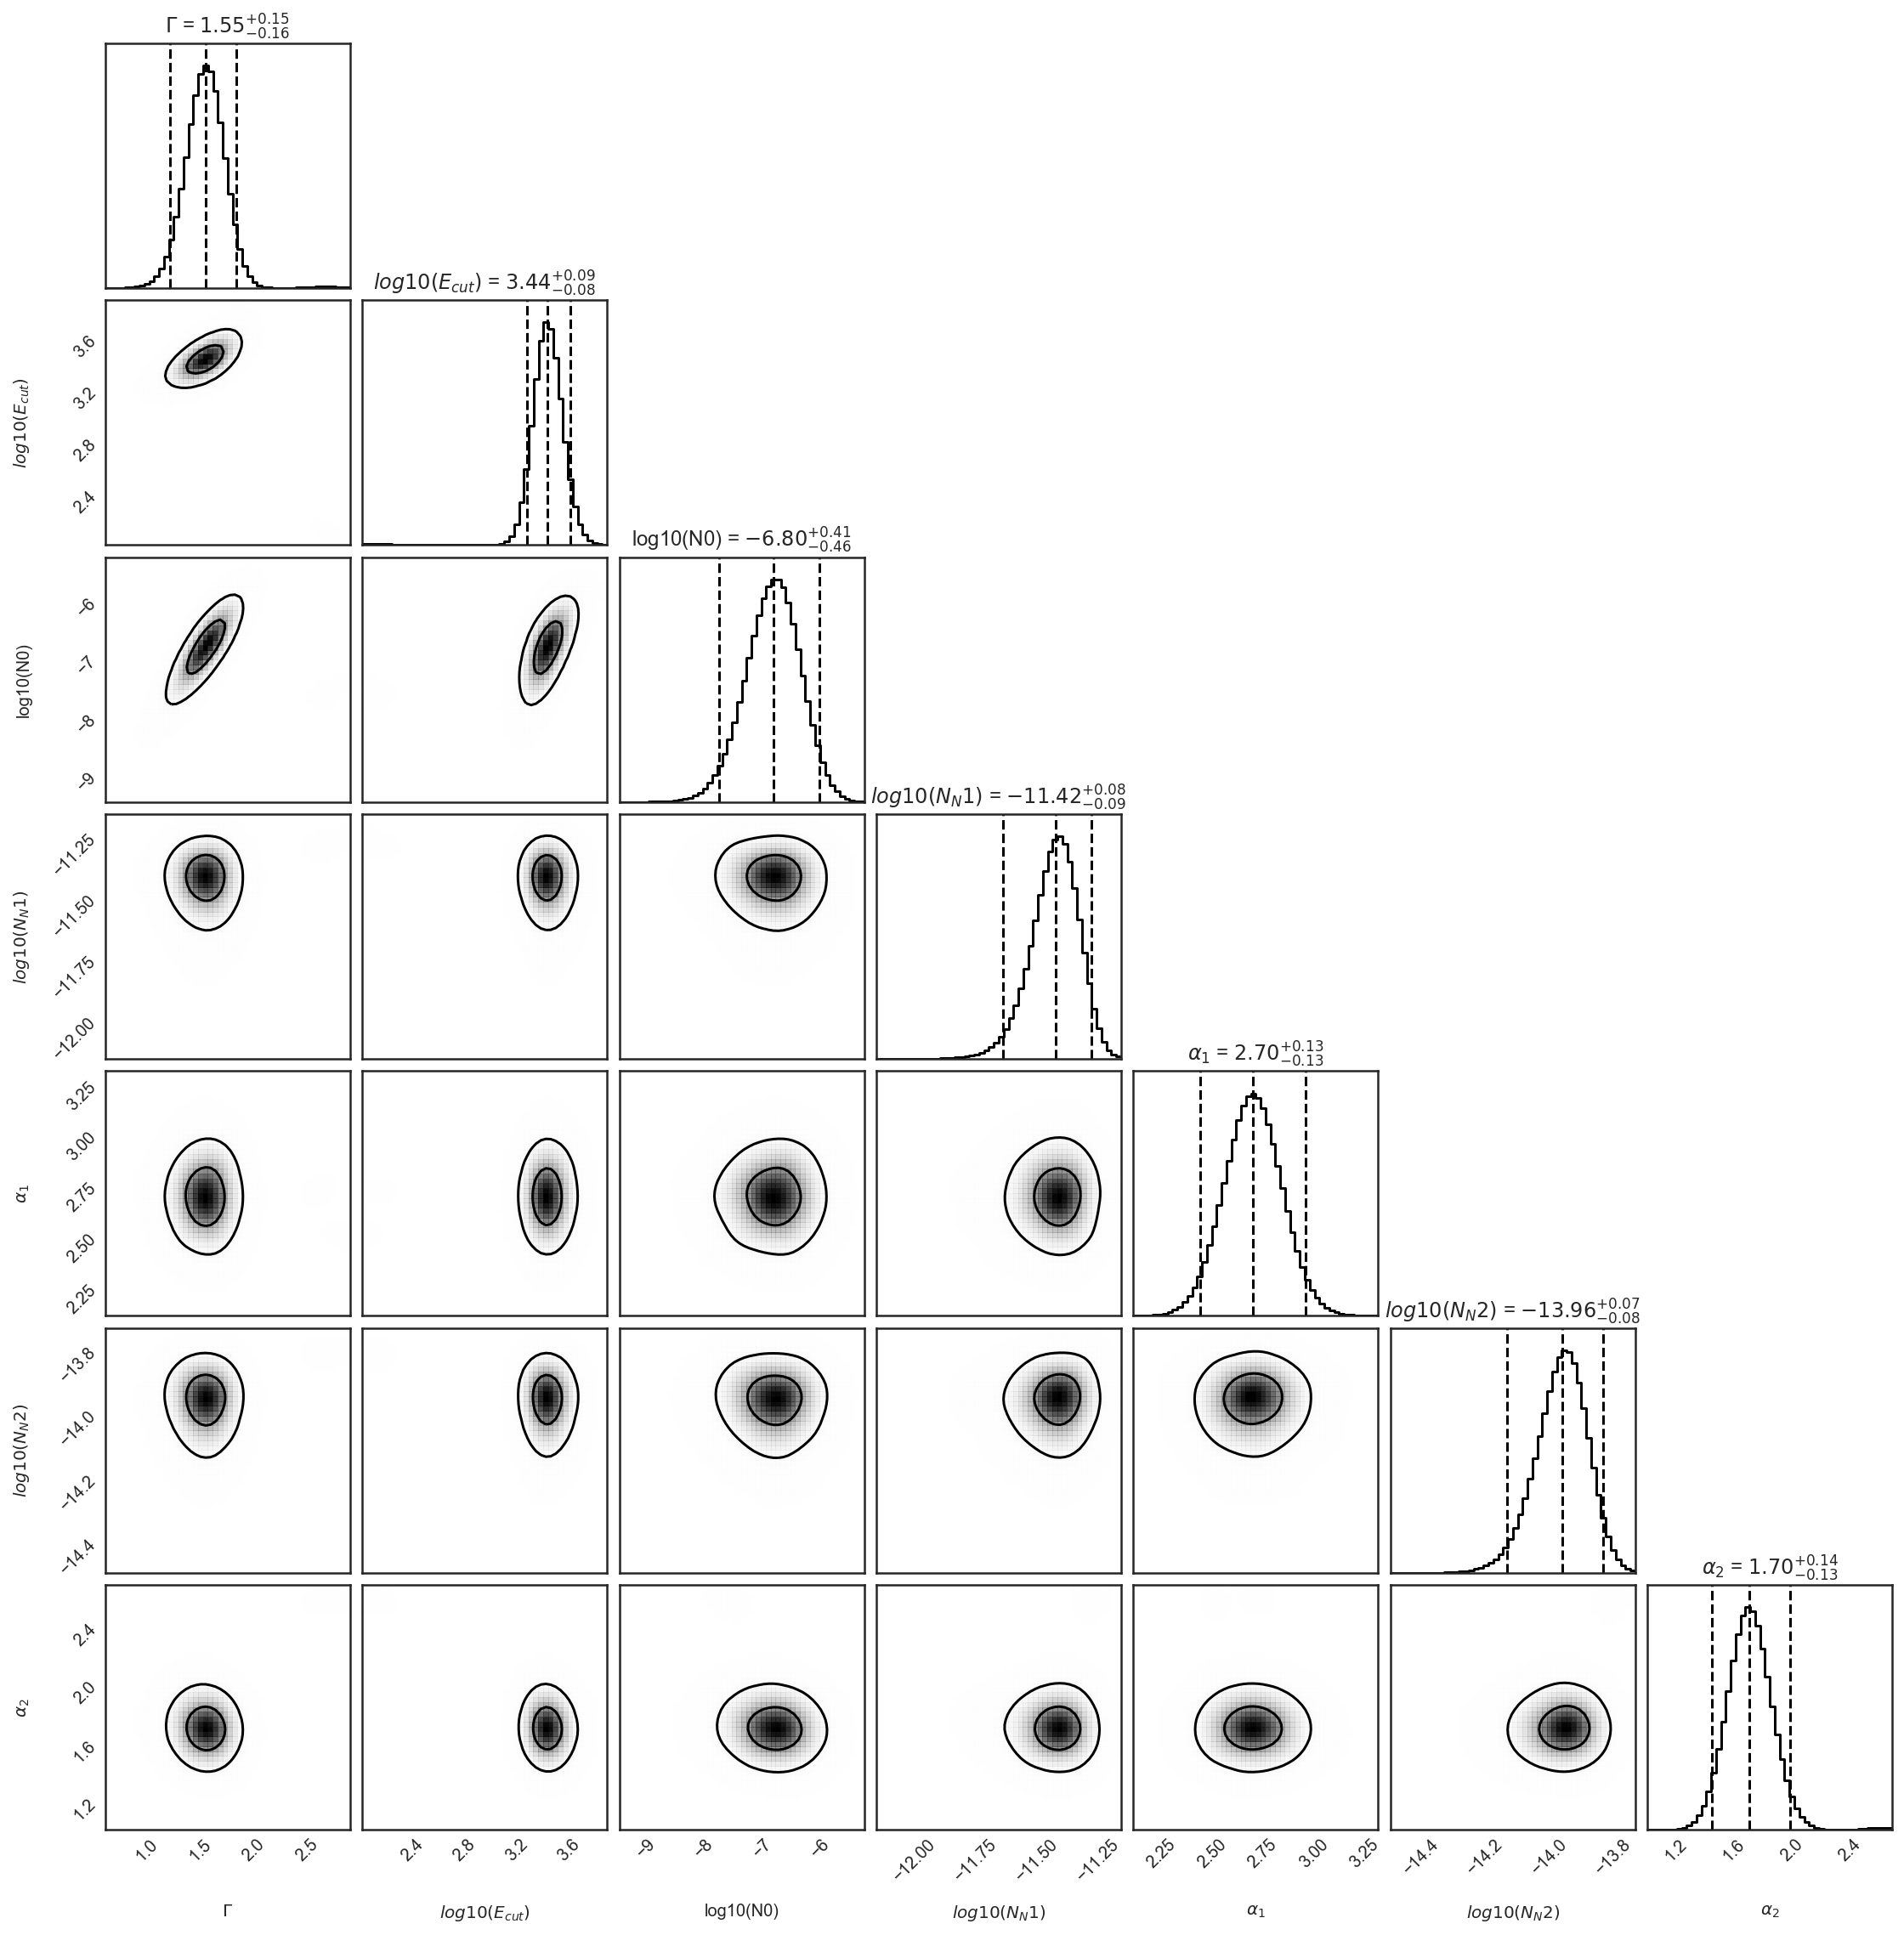

In [43]:
fig = corner.corner(sampler.flatchain,bins=50,labels=labels,plot_datapoints=False,smooth=2., 
                    smooth1d=2,levels=(1.-np.exp(-0.5),1.-np.exp(-2.)),quantiles=[.025,0.5,0.975],show_titles=True);

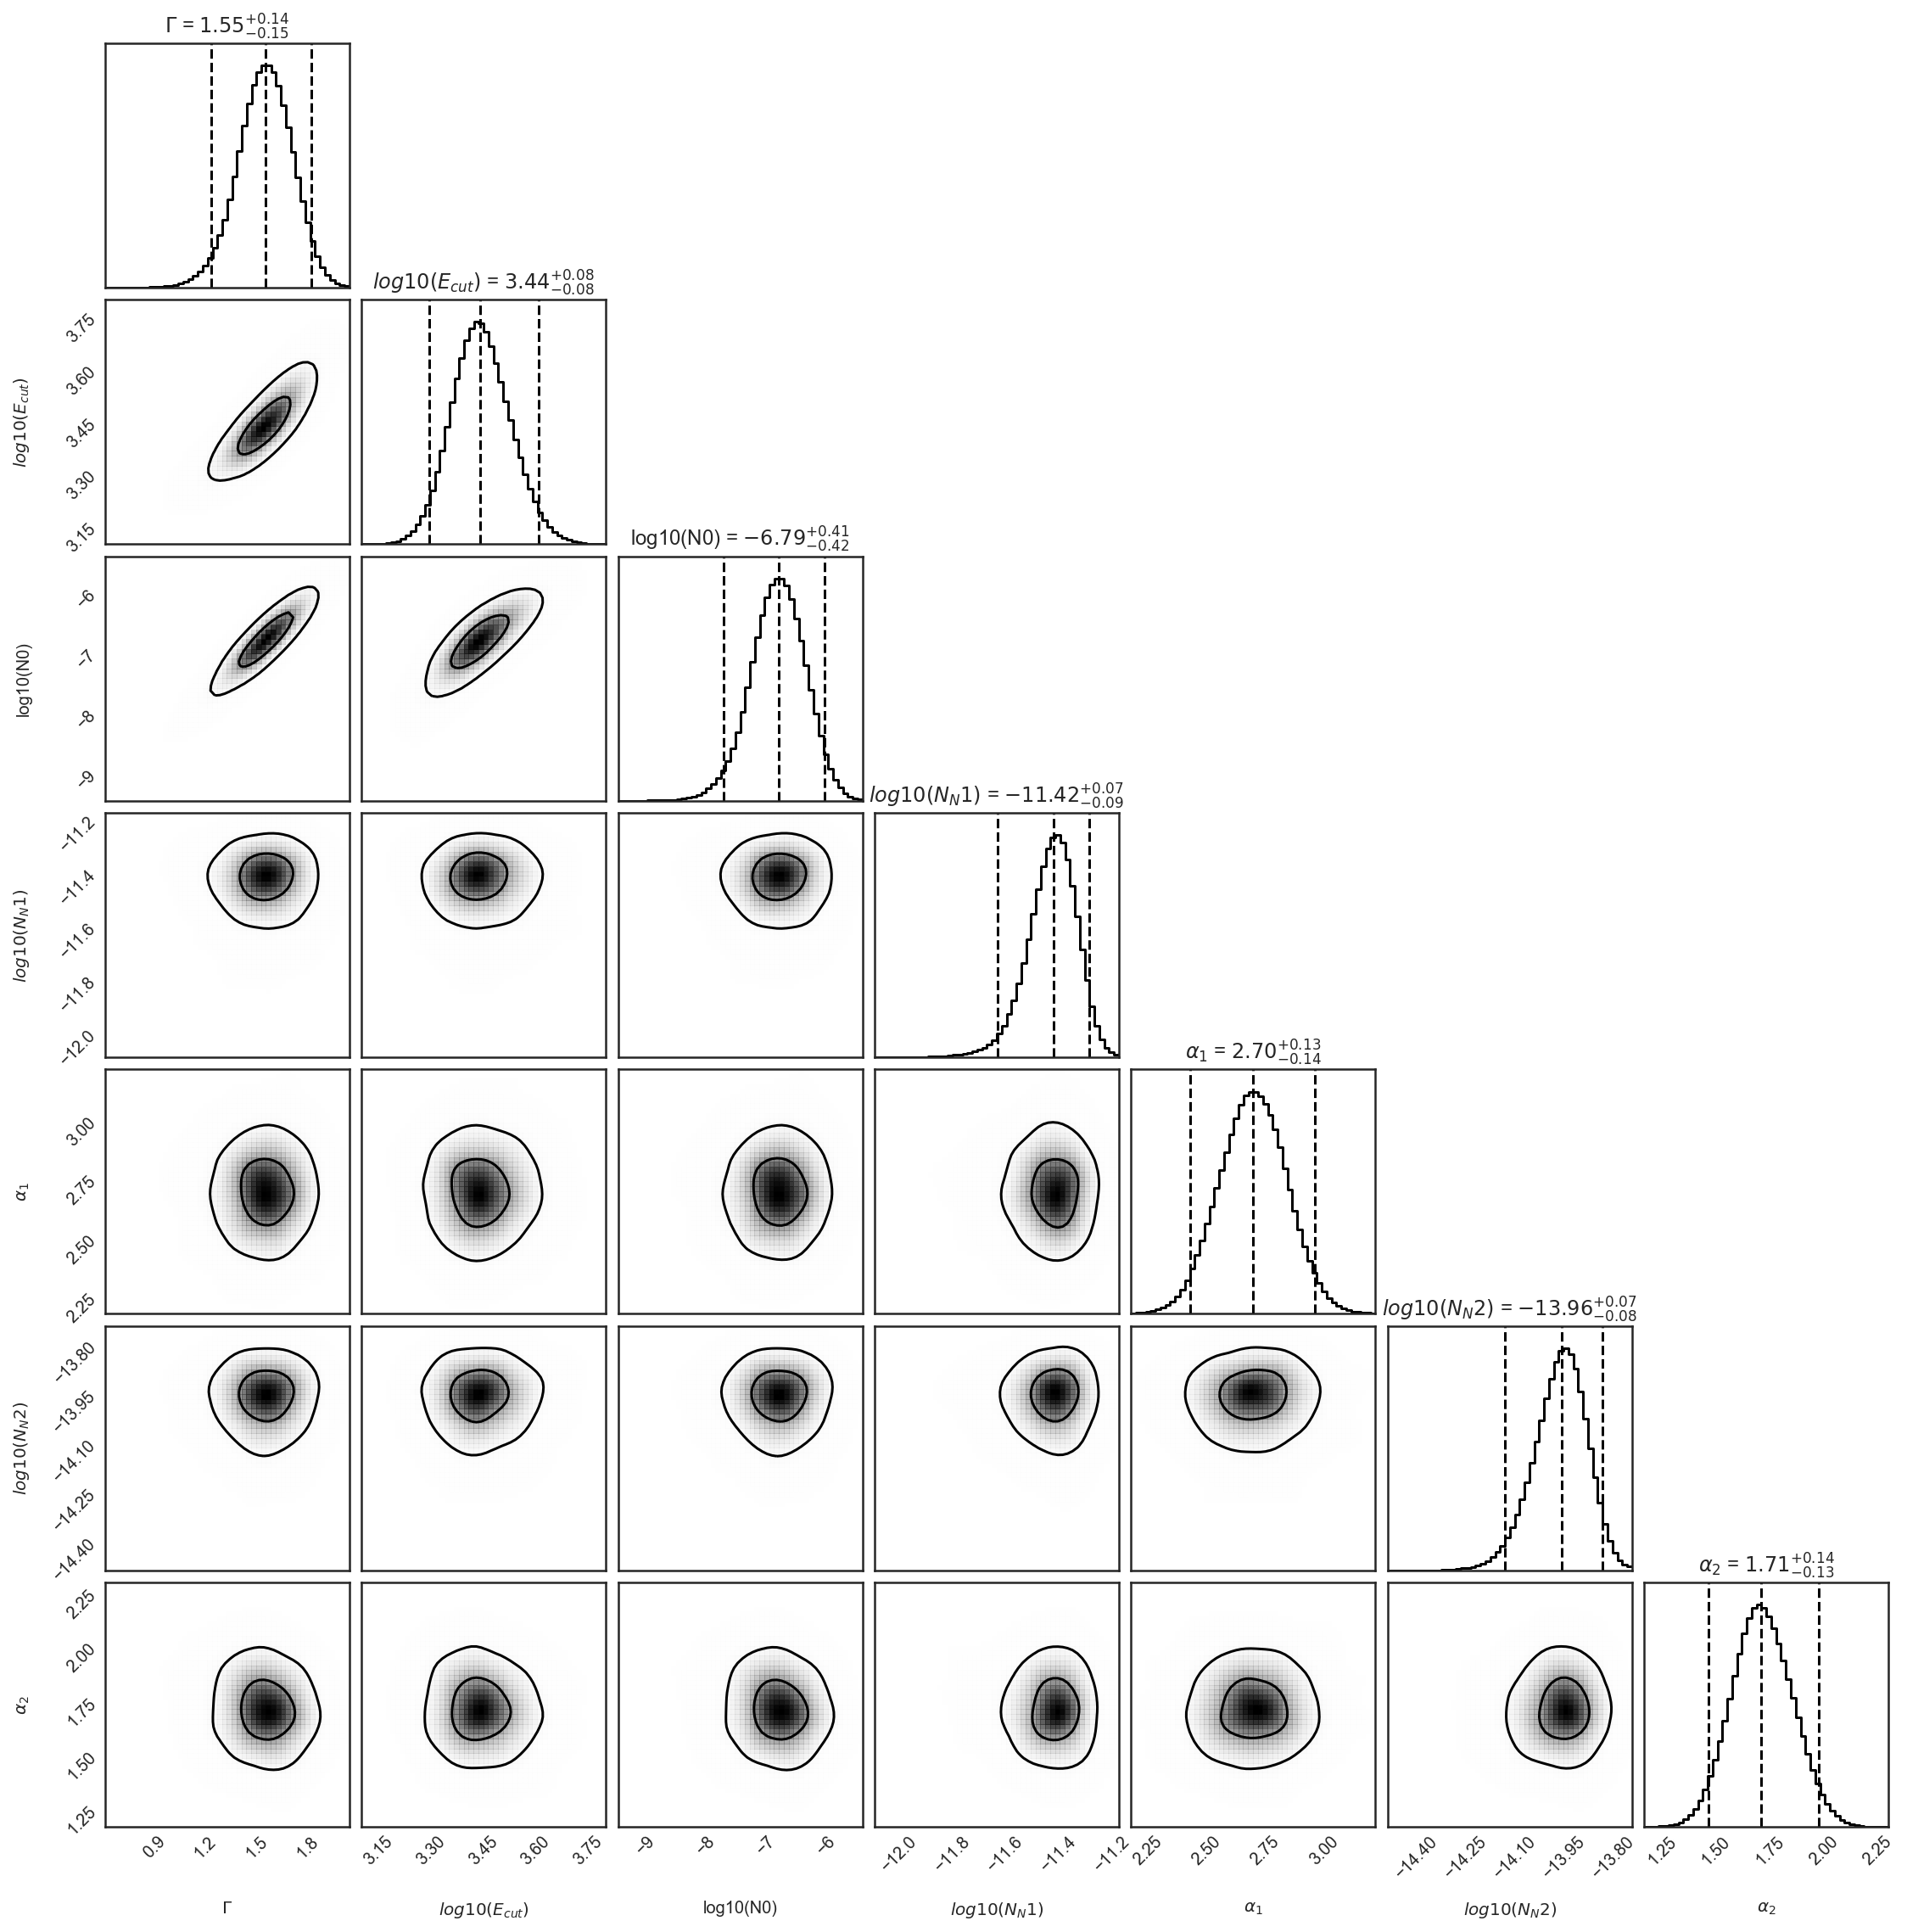

In [47]:
fig_1 = corner.corner(sampler.flatchain[155000:],bins=50,labels=labels,plot_datapoints=False,smooth=2., 
                    smooth1d=2,levels=(1.-np.exp(-0.5),1.-np.exp(-2.)),quantiles=[.025,0.5,0.975],show_titles=True);

fig_1.savefig('images/joint_lnhood_plot_gauss.pdf')

Text(0,0.5,u'No_Events')

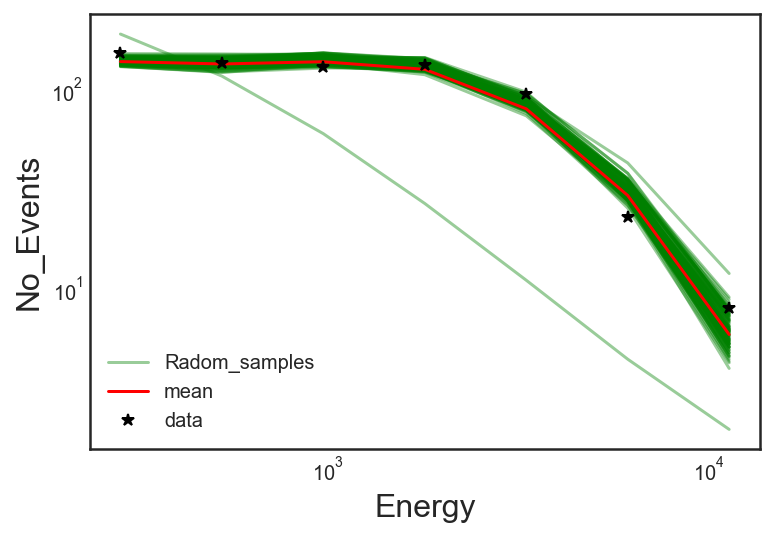

In [27]:
fig1 = plt.figure()

for c1,c2,c3,c4,c5,c6,c7 in sampler.flatchain[np.random.randint(len(sampler.flatchain), size=100)]:
    val_1 = no_events_ocen([c1,c2,c3],e_min,e_max)
    val_2 = no_events_source1([c4,c5],e_min,e_max)
    val_3 = no_events_source2([c6,c7],e_min,e_max)
    fig_1,=plt.loglog(Ener,val_1+val_2+val_3,'g',alpha=0.4);

val1_mean = no_events_ocen([np.mean(sampler.flatchain[:,0]),np.mean(sampler.flatchain[:,1]),np.mean(sampler.flatchain[:,2])],
                                   e_min,e_max)
val2_mean = no_events_source1([np.mean(sampler.flatchain[:,3]),np.mean(sampler.flatchain[:,4])],
                             e_min,e_max)
val3_mean = no_events_source2([np.mean(sampler.flatchain[:,5]),np.mean(sampler.flatchain[:,6])],
                             e_min,e_max)

fig_2,=plt.loglog(Ener,val1_mean+val2_mean+val3_mean,'r');
#fig_2,=plt.plot(Ener,no_events_model_pulsar([np.mean(sampler.flatchain[:,0]),np.mean(sampler.flatchain[:,1]),np.mean(sampler.flatchain[:,2])],e_min,e_max)+ background);
#plt.plot(Ener,no_events,'*b');
fig_3,=plt.loglog(Ener,no_events,'*k');
plt.legend([fig_1,fig_2,fig_3],['Radom_samples','mean','data'],loc='best')
plt.xlabel('Energy',fontsize=16)
plt.ylabel('No_Events',fontsize=16)
#plt.plot(Ener,no_events_model_pulsar([-0.23,3.14,-1.18],e_min,e_max),'b');

fig1.savefig('images/No_events_gauss.pdf')

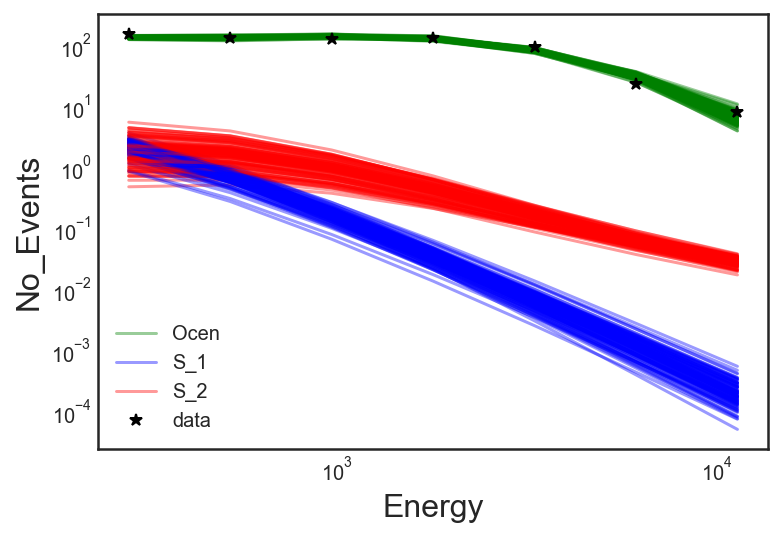

In [34]:
fig1 = plt.figure()
for c1,c2,c3,c4,c5,c6,c7 in sampler.flatchain[np.random.randint(len(sampler.flatchain), size=100)]:
    val_1 = no_events_ocen([c1,c2,c3],e_min,e_max)
    val_2 = no_events_source1([c4,c5],e_min,e_max)
    val_3 = no_events_source2([c6,c7],e_min,e_max)
    fig_1,=plt.loglog(Ener,val_1,'g',alpha=0.4);
    fig_2,=plt.loglog(Ener,val_2,'b',alpha=0.4);
    fig_3,=plt.loglog(Ener,val_3,'r',alpha=0.4);


#fig_2,=plt.plot(Ener,no_events_model_pulsar([np.mean(sampler.flatchain[:,0]),np.mean(sampler.flatchain[:,1]),np.mean(sampler.flatchain[:,2])],e_min,e_max)+ background);
#plt.plot(Ener,no_events,'*b');
fig_4,=plt.loglog(Ener,no_events,'*k');
plt.legend([fig_1,fig_2,fig_3,fig_4],['Ocen','S_1','S_2','data'],loc='best');
plt.xlabel('Energy',fontsize=16);
plt.ylabel('No_Events',fontsize=16);
#plt.plot(Ener,no_events_model_pulsar([-0.23,3.14,-1.18],e_min,e_max),'b');

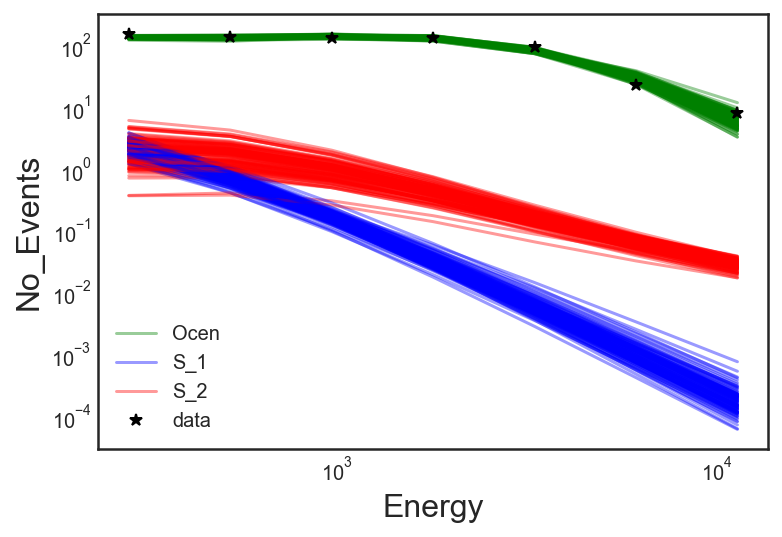

In [46]:
fig1 = plt.figure()
chains_redux = sampler.flatchain[155000:]
for c1,c2,c3,c4,c5,c6,c7 in chains_redux[np.random.randint(len(chains_redux), size=100)]:
    val_1 = no_events_ocen([c1,c2,c3],e_min,e_max)
    val_2 = no_events_source1([c4,c5],e_min,e_max)
    val_3 = no_events_source2([c6,c7],e_min,e_max)
    fig_1,=plt.loglog(Ener,val_1,'g',alpha=0.4);
    fig_2,=plt.loglog(Ener,val_2,'b',alpha=0.4);
    fig_3,=plt.loglog(Ener,val_3,'r',alpha=0.4);


#fig_2,=plt.plot(Ener,no_events_model_pulsar([np.mean(sampler.flatchain[:,0]),np.mean(sampler.flatchain[:,1]),np.mean(sampler.flatchain[:,2])],e_min,e_max)+ background);
#plt.plot(Ener,no_events,'*b');
fig_4,=plt.loglog(Ener,no_events,'*k');
plt.legend([fig_1,fig_2,fig_3,fig_4],['Ocen','S_1','S_2','data'],loc='best');
plt.xlabel('Energy',fontsize=16);
plt.ylabel('No_Events',fontsize=16);
#plt.plot(Ener,no_events_model_pulsar([-0.23,3.14,-1.18],e_min,e_max),'b');

In [49]:
def N_Pulsars_Ecut(chains):

    d = 5.2 * (1000.*100.) * 3.0857e16 #cm
    eta = 0.08
    E_dot = 2.0e34
    
    S = np.zeros(len(chains))
    
    for i in range(len(chains)):
        
        C_s = [chains[i,0],chains[i,1],chains[i,2]]
        integrand = lambda x: x * E2dNdE_pulsar(C_s,x)
        
        S[i] = integrate.quad(integrand,0.01,np.inf)[0]
    
    L = 4.0 * np.pi * S * d**2
    N_events = (L*1.602e-6) /(E_dot * eta)
    
    return N_events

In [50]:
chain_Np = N_Pulsars_Ecut(chains_redux)

In [51]:
new_chain = np.append(chains_redux,chain_Np[:,None],axis=1)

In [52]:
labels_2 = [r'$\Gamma$',r'$log10(E_{cut})$','log10(N0)'
          ,r'$log10(N_N1)$',r'$\alpha_1$'
         ,r'$log10(N_N2)$',r'$\alpha_2$',r'$N_{Pulsars}$']

In [63]:
ranges = ((0.9,2.), (3.,4.), (-9.,-5.),(-12.,-11.),(2,3.5),(-15.,-13.6),(1,2.5),(0,100))

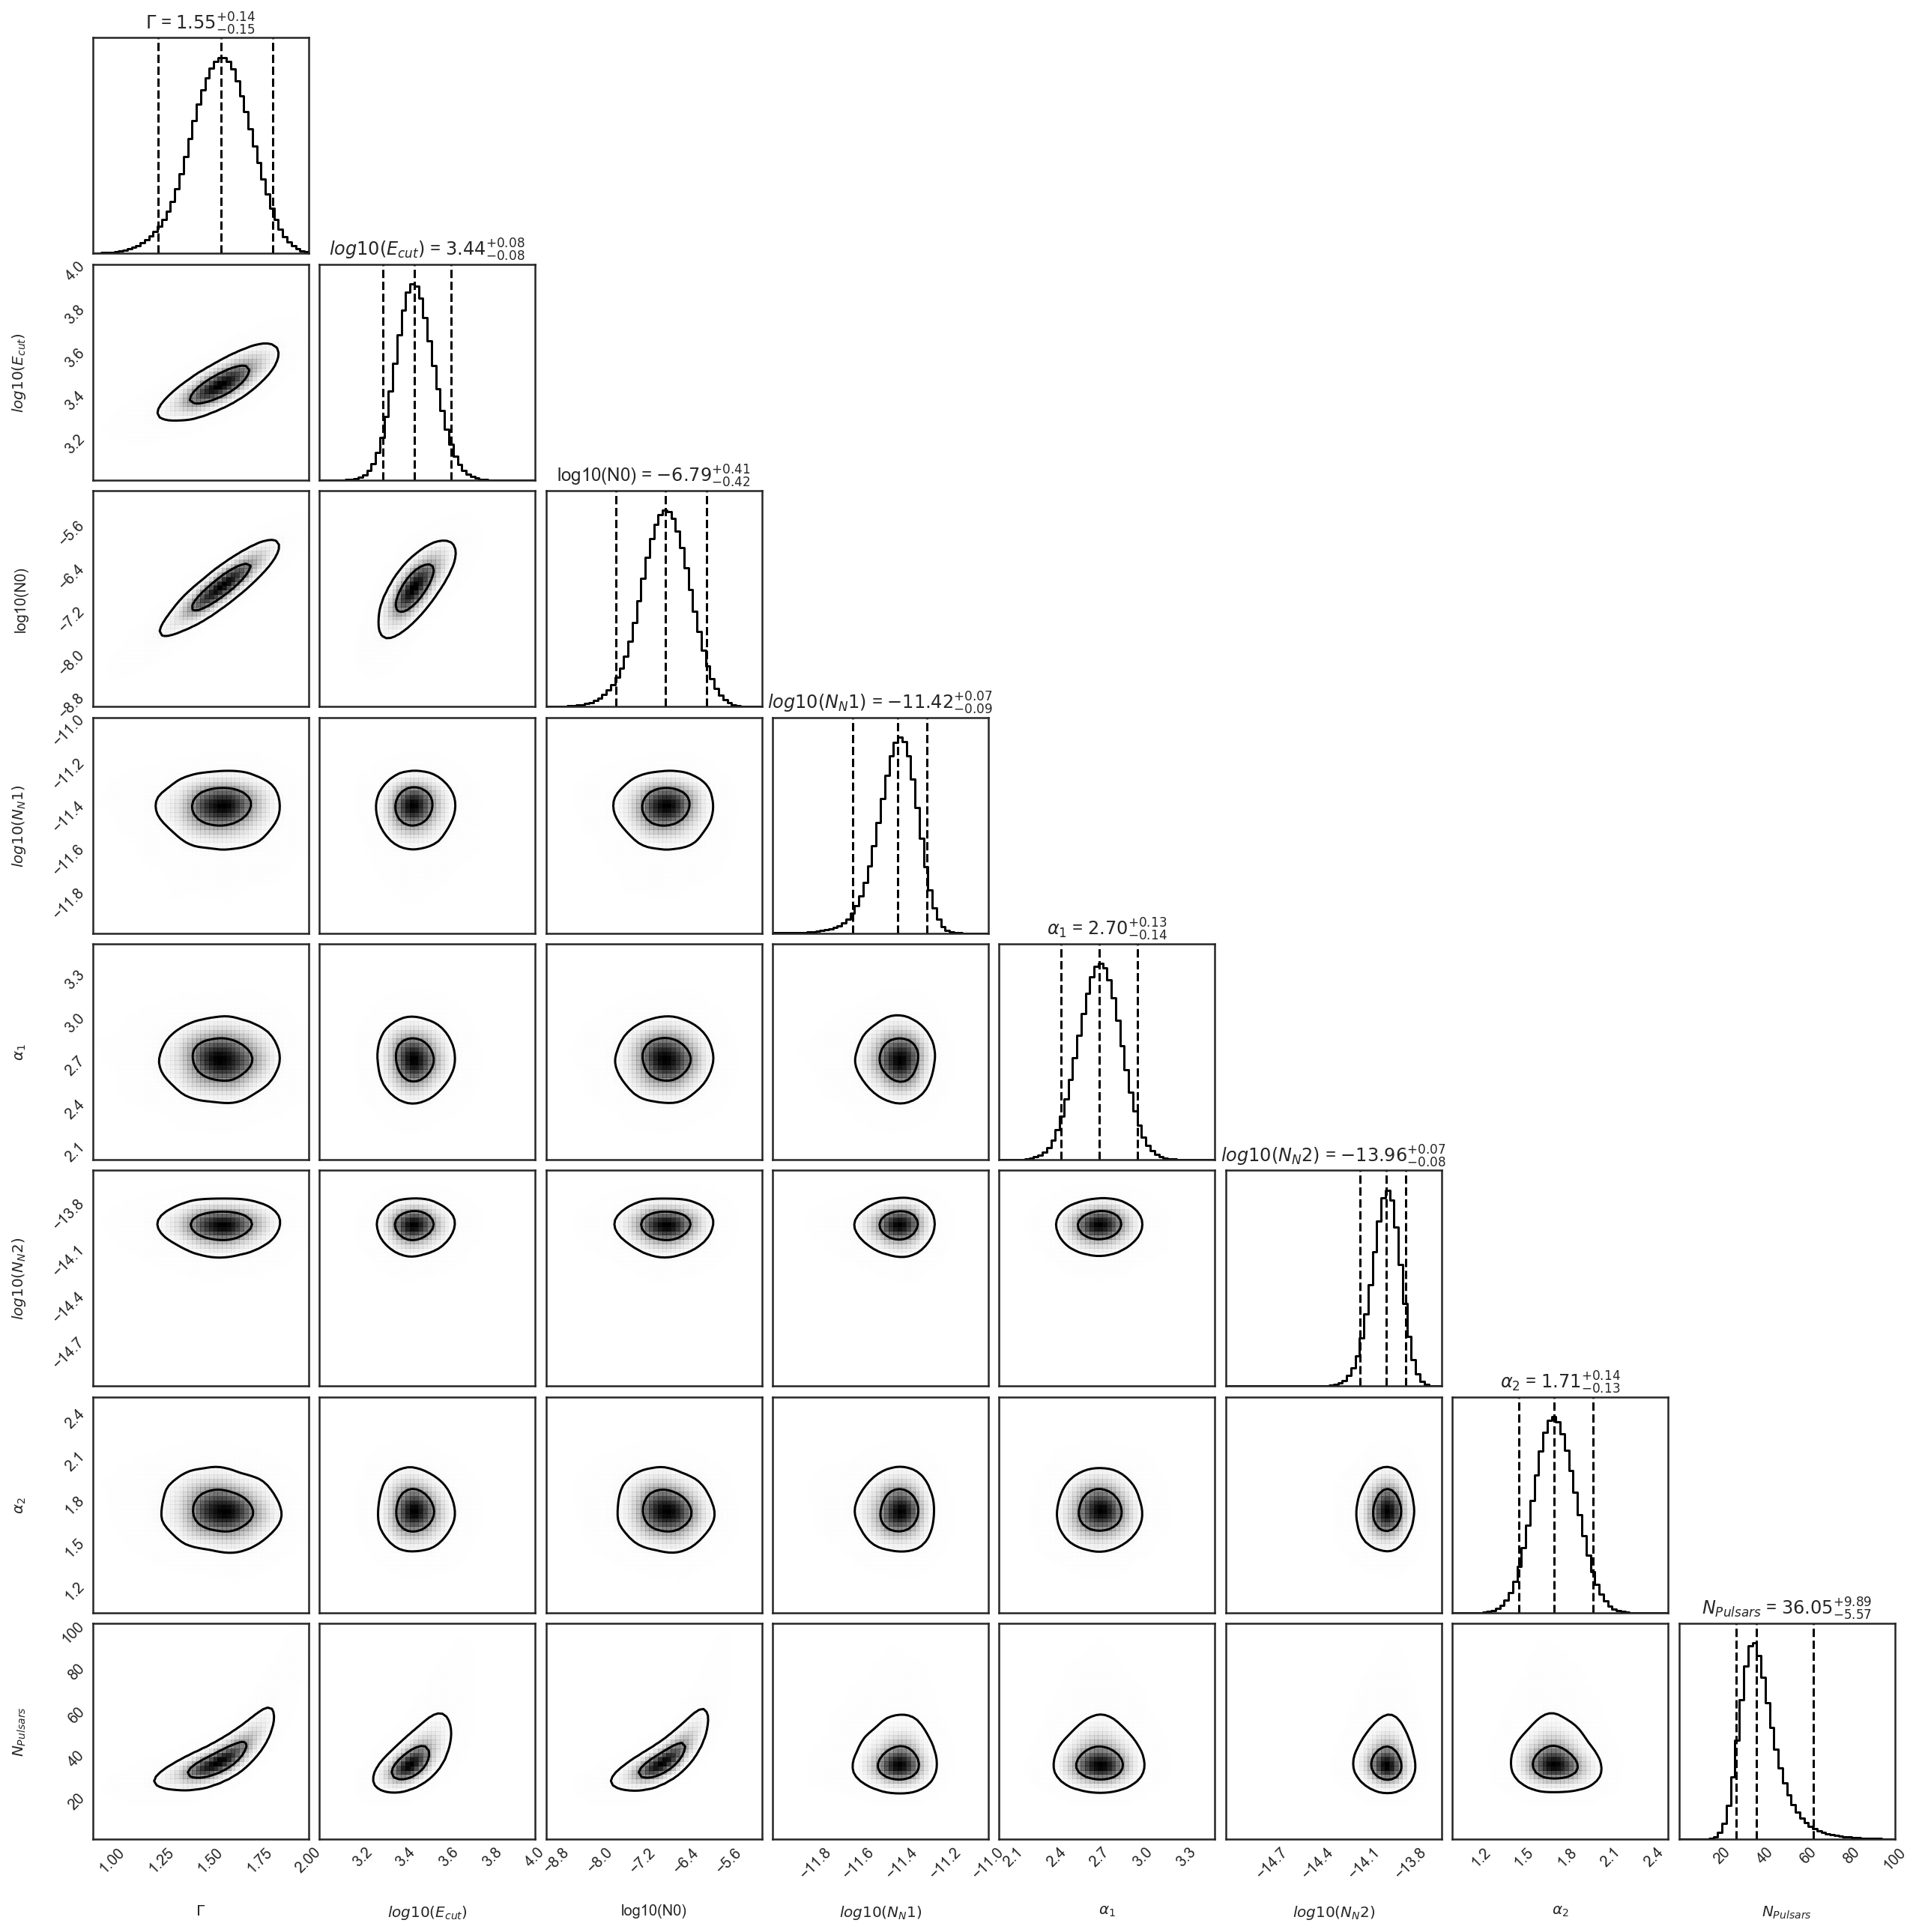

In [64]:
fig_count= corner.corner(new_chain,bins=50,range=ranges,labels=labels_2,plot_datapoints=False,smooth=2., 
                    smooth1d=2,levels=(1.-np.exp(-0.5),1.-np.exp(-2.)),quantiles=[.025,0.5,0.975],show_titles=True);

In [66]:
#fig_count.savefig('images/joint_like_events.pdf')

In [65]:
#np.savetxt('chains/joint_like_gauss.dat',sampler.flatchain)